# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [2]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter

In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

## Get Data from Webpage and Save to CSV

Do this step one time only and save the table to a csv file

`pip3 install lxml html5lib`

In [4]:
if 0:
    df = pd.read_html(
        r"https://www.mammothmountain.com/on-the-mountain/snowfall-history#tab=historical%20df"
    )[0]
    df.to_csv("./data/mammoth_mountain_snowfall.csv")

## Read table

In [5]:
df = pd.read_csv("./data/mammoth_mountain_snowfall.csv")
display(df.head())

,Unnamed: 0,Season,Total,Pre-Oct,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
0,0,2023-24,354.0,0,0.0,14.0,12.0,72.0,133.0,95.0,28.0,NaN,NaN,NaN
1,1,2022-23,715.0,0,0.0,61.0,116.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2,2021-22,260.0,0,32.0,9.0,161.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0
3,3,2020-21,244.5,0,0.0,21.0,33.0,108.5,22.0,53.0,5.0,2.0,0.0,0.0
4,4,2019-20,281.0,0,0.0,54.0,71.0,13.0,0.0,83.0,57.0,3.0,0.0,0.0


## Light Cleanups

Some cleanups to do
- Drop dummy row index column and total snowfall per year
- Fill NaN with 0
- Flip from top to bottom to make oldest to newest
- Reorganize by calendar year and month rather than season
- Set index as date in datetime format
- Divide Pre-Oct column into August and September
    - For now, use an even split
    - Should more actually go to September?

In [70]:
df = pd.read_csv("./data/mammoth_mountain_snowfall.csv")
# print("read")
# display(df.head(3))

# print("fillna and dummy drop")
df = df.fillna(0).drop(columns=["Unnamed: 0", "Total"])
# display(df.head(3))

# print("Split pre-october")
df.insert(loc=1, column="Sep", value=0.5 * df["Pre-Oct"])
df.insert(loc=1, column="Aug", value=0.5 * df["Pre-Oct"])
df.drop(columns="Pre-Oct", inplace=True)
# display(df.head(3))

# print("Remove trailing dash from season and convert to int")
df["Season"] = df["Season"].apply(lambda x: int(x.split("-")[0]))
# display(df.head(3))

# print("Renamed season to Year")
df.rename(columns={"Season": "Winter Year"}, inplace=True)
# display(df.head(3))

print("Add current year column for spring months")
df.insert(
    loc=df.columns.get_loc("Jan"),
    column="Spring Year",
    value=df["Winter Year"] + 1,
)

display(df.head(3))

# print("This year")
current_year = df[df.columns[: df.columns.get_loc("Spring Year")]]
# display(current_year.head(3))

# print("Next year")
next_year = df[df.columns[df.columns.get_loc("Spring Year") :]]
# display(next_year.head(3))

print("Merge on year columns")
df = (
    pd.merge(
        current_year,
        next_year,
        left_on="Winter Year",
        right_on="Spring Year",
        how="outer",
    )
    .fillna(0)
    .iloc[::-1]
    .reset_index(drop=True)
)
display(df.head(3))

print("Fill in 0 Values For 2 Edge Years and Drop")
df.insert(loc=0, column="Year", value=df[["Winter Year", "Spring Year"]].max(axis=1))
df.drop(columns=["Winter Year", "Spring Year"], inplace=True)
display(df.head(3))

Add current year column for spring months


,Winter Year,Aug,Sep,Oct,Nov,Dec,Spring Year,Jan,Feb,Mar,Apr,May,Jun,Jul
0,2023,0.0,0.0,0.0,14.0,12.0,2024,72.0,133.0,95.0,28.0,0.0,0.0,0.0
1,2022,0.0,0.0,0.0,61.0,116.0,2023,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2021,0.0,0.0,32.0,9.0,161.0,2022,0.0,7.0,14.0,34.0,3.0,0.0,0.0


Merge on year columns


,Winter Year,Aug,Sep,Oct,Nov,Dec,Spring Year,Jan,Feb,Mar,Apr,May,Jun,Jul
0,0.0,0.0,0.0,0.0,0.0,0.0,2024.0,72.0,133.0,95.0,28.0,0.0,0.0,0.0
1,2023.0,0.0,0.0,0.0,14.0,12.0,2023.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2022.0,0.0,0.0,0.0,61.0,116.0,2022.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0


Fill in 0 Values For 2 Edge Years and Drop


,Year,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
0,2024.0,0.0,0.0,0.0,0.0,0.0,72.0,133.0,95.0,28.0,0.0,0.0,0.0
1,2023.0,0.0,0.0,0.0,14.0,12.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2022.0,0.0,0.0,0.0,61.0,116.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0


In [52]:
df.tail()

,Year,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
51,1973.0,22.5,22.5,0.0,0.0,45.0,84.9,103.0,43.0,10.0,4.0,0.0,0.0
52,1972.0,2.0,2.0,0.0,57.1,64.5,32.2,11.0,1.0,53.5,0.0,0.0,0.0
53,1971.0,11.0,11.0,0.0,9.0,139.8,29.0,19.5,24.0,14.0,0.0,0.0,0.0
54,1970.0,30.0,30.0,0.0,0.0,109.0,78.0,30.5,46.0,27.0,0.0,0.0,0.0
55,1969.0,11.0,11.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Melt to Break Out Months to Rows

In [72]:
df = (
    pd.melt(
        df,
        id_vars=df.columns[0],
        value_vars=df.columns[1:],
        var_name="Month",
        value_name="Snow Fall",
    )
    .sort_values(by="Year")
    .iloc[::-1]
    .reset_index(drop=True)
)
df.head()

,Year,Month,Snow Fall
0,2024.0,Aug,0.0
1,2024.0,Jun,0.0
2,2024.0,Mar,95.0
3,2024.0,Feb,133.0
4,2024.0,Jan,72.0


In [ ]:
# Set Date

<Axes: >

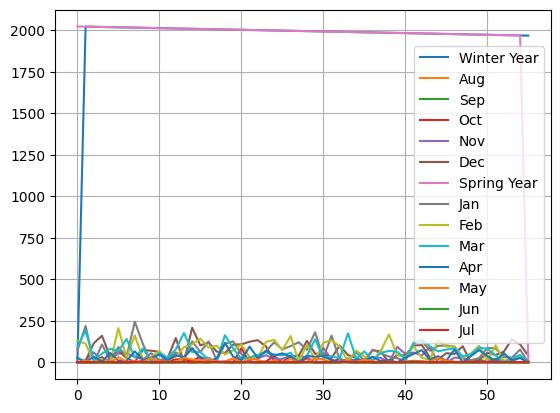

In [43]:
df.plot()

# Assess Stationarity of Data

# Construct ARIMA Model

## Model Setup

## Search for p and q

## Best Model Selection

## Plot Observed and Fit

# Assess Residue